In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

# default: Load the model on the available device(s)
model = Qwen3VLForConditionalGeneration.from_pretrained(
    "weathon/smolvlm2_anti_aesthetics_7b", dtype="auto", device_map="cuda"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-4B-Instruct")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
from datasets import load_dataset
dataset = load_dataset("weathon/aas_benchmark")

In [3]:
import pandas as pd

df = pd.read_csv("rules.csv")
sign = lambda x: (x > 0) - (x < 0)
import pandas as pd
import re

df.columns = df.columns.str.strip()
df['Dimension'] = df['Dimension'].ffill()

df['dim_key'] = df['Dimension'].apply(lambda x: re.search(r'\((.*?)\)', x).group(1) if re.search(r'\((.*?)\)', x) else x)

guide = {
    dim_key: {
        f"{row['Option']}: {sign(int(row['Score']))+1}": ": " +str(row['Description']).strip()
        for _, row in group.iterrows()
    }
    for dim_key, group in df.groupby('dim_key')
}

score = {
    dim_key: {
        int(row['Score']): str(row['Option']).strip()
        for _, row in group.iterrows()
    }
    for dim_key, group in df.groupby('dim_key')
}


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_original', 'image_distorted', 'index', 'prompt_original', 'prompt_distorted', 'selected_dims', 'hpsv2', 'llm_judge', 'model', 'hpsv2_reward', 'hpsv3_reward', 'image_reward'],
        num_rows: 3300
    })
})

In [5]:
dataset = dataset["train"]

lighting distinction
['0']
tensor(0.3770, device='cuda:0', dtype=torch.bfloat16)


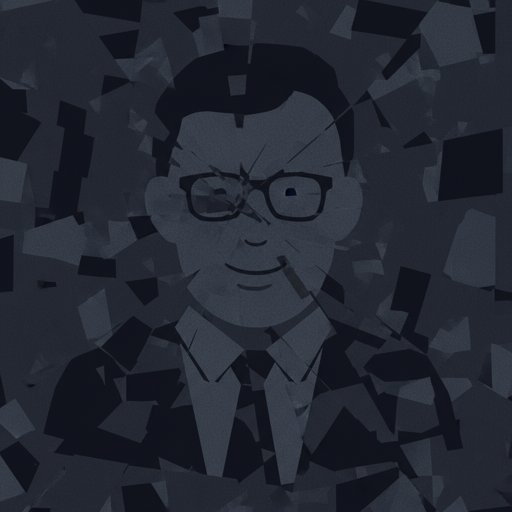

In [62]:
import json
idx = 182
dim = json.loads(dataset[idx]["selected_dims"])[0]
print(dim)
messages = [
            { 
                "role": "user",
                "content": [
                    {
                        "type":"text",
                        "text":f"Please rate this image for its {dim} quality. Use this guideline {guide[dim]}. Response a single number.",
                    },
                    {
                        "type": "image", 
                        "image": dataset[idx]["image_distorted"].resize((512, 512))
                    }
                ],
            }]

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
) 

inputs = inputs.to(model.device)

generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
) 
print(output_text) 
id_of_interest = processor.tokenizer.convert_tokens_to_ids(["0", "1", "2"])
id_of_interest
import torch
with torch.no_grad():
    logits = model(**inputs, max_new_tokens=128).logits
prob = torch.softmax(logits[:, -1], dim=-1)
prob_of_interest = prob[:, id_of_interest][0]
score = torch.dot(prob_of_interest, torch.tensor([0, 1, 2], device=prob_of_interest.device).bfloat16())
print(score)

dataset[idx]["image_distorted"].resize((512, 512))


In [9]:
# from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

# # default: Load the model on the available device(s)
# model = Qwen3VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen3-VL-4B-Instruct", dtype="auto", device_map="cuda:1" 
# )

# # We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# # model = Qwen3VLForConditionalGeneration.from_pretrained(
# #     "Qwen/Qwen3-VL-4B-Instruct",
# #     dtype=torch.bfloat16,
# #     attn_implementation="flash_attention_2",
# #     device_map="auto",
# # )

# processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-4B-Instruct")

In [10]:
# from datasets import load_dataset
# dataset = load_dataset("weathon/aas_benchmark")

In [11]:
# dataset = dataset["train"]

In [12]:
# import json
# dim = json.loads(dataset[0]["selected_dims"])[0]
# messages = [
#             { 
#                 "role": "user",
#                 "content": [
#                     {
#                         "type":"text",
#                         "text":f"Please rate this image for its {dim} quality. Use this guideline {guide[dim]}. Response a single number. **Rate on the lower end.**",
#                     },
#                     {
#                         "type": "image", 
#                         "image": dataset[0]["image_distorted"]
                            
#                     }
#                 ],
#             }]

# # Preparation for inference
# inputs = processor.apply_chat_template(
#     messages,
#     tokenize=True,
#     add_generation_prompt=True,
#     return_dict=True,
#     return_tensors="pt"
# )
# inputs = inputs.to(model.device)

# # Inference: Generation of the output
# generated_ids = model.generate(**inputs, max_new_tokens=128)
# generated_ids_trimmed = [
#     out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
# ]
# output_text = processor.batch_decode(
#     generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# )
# print(output_text) 
